In [4]:
# Import packages
import pandas as pd
import numpy as np
from sklearn import linear_model
import requests
# from nba_api.stats import endpoints
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup

In [77]:
import scipy
import emcee
import numba
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set()
current_palette = sns.color_palette()

## Problem Statement

This is one of the most debatable questions that raises each year... We want to propuse new inovative method for choosing MVP. Explain how MVP is chosen, what is the PER formula. Let's first try to unserstand why this is a problem.

In [6]:
mvp_dict = {2019: 'Giannis Antetokounmpo',2018: 'James Harden',2017: 'Russell Westbrook',2016: 'Stephen Curry',2015: 'Stephen Curry',2014: 'Kevin Durant',2013: 'LeBron James',2012: 'LeBron James',2011: 'Derrick Rose',2010: 'LeBron James',2009: 'LeBron James',2008: 'Kobe Bryant',2007: 'Dirk Nowitzki',2006: 'Steve Nash',2005: 'Steve Nash',2004: 'Kevin Garnett',2003: 'Tim Duncan',2002: 'Tim Duncan',2001: 'Allen Iverson',1900: "Shaquille O'Neal",1999: 'Karl Malone',1998: 'Michael Jordan',1997: 'Karl Malone',1996: 'Michael Jordan',1995: 'David Robinson',1994: 'Hakeem Olajuwon',1993: 'Charles Barkley',1992: 'Michael Jordan',1991: 'Michael Jordan',1990: 'Magic Johnson',1989: 'Magic Johnson',1988: 'Michael Jordan',1987: 'Magic Johnson',1986: 'Larry Bird',1985: 'Larry Bird',1984: 'Larry Bird',1983: 'Moses Malone',1982: 'Moses Malone',1981: 'Julius Erving',1980: 'Kareem Abdul-Jabbar',1979: 'Moses Malone',1978: 'Bill Walton',1977: 'Kareem Abdul-Jabbar',1976: 'Kareem Abdul-Jabbar',1975: 'Bob McAdoo',1974: 'Kareem Abdul-Jabbar',1973: 'Dave Cowens',1972: 'Kareem Abdul-Jabbar',1971: 'Kareem Abdul-Jabbar',1970: 'Willis Reed',1969: 'Wes Unseld',1968: 'Wilt Chamberlain',1967: 'Wilt Chamberlain',1966: 'Wilt Chamberlain',1965: 'Bill Russell',1964: 'Oscar Robertson',1963: 'Bill Russell',1962: 'Bill Russell',1961: 'Bill Russell',1960: 'Wilt Chamberlain',1959: 'Bob Pettit',1958: 'Bill Russell',1957: 'Bob Cousy',1956: 'Bob Pettit'}

In [7]:
class nbaDataFetch(object):
    def __init__(self):
        self.min_games = 20
        self.mvps_dict = mvp_dict
        
    def get_url(self, stats='basic', year=None):
        # 'basic' / 'advanced' (with PER)
        if stats is 'basic':
            url = 'https://www.basketball-reference.com/leagues/NBA_{}_per_game.html'.format(year)
        elif stats is 'advanced':
            url = 'https://www.basketball-reference.com/leagues/NBA_{}_advanced.html'.format(year) # advanced statistics - with PER
        else:
            print("Unknown stats mode: Please choose 'basic' / 'advanced'")
        print('fetching url:\n{}'.format(url))
        return url
    
    def convert_df_to_numeric(self, df, columns_to_convert_to_numeric):
        for col in columns_to_convert_to_numeric:
            df[col] = pd.to_numeric(df[col])
        return df
    
    def preprocess_df(self, original_df, columns_to_convert_to_numeric):
        df = original_df.copy()
        df['Player'] = df['Player'].str.replace('*', '')
        if '\xa0' in df.columns: # Empty column
            df.drop(columns=['\xa0'], inplace=True)
        df.replace('', np.nan, inplace=True) # convert '' to nan in order to use dropna
        df.dropna(inplace=True)  # Remove players with empty stats (didn't play enough)

        # Remove Players with multiple positions (only 4 such players)
        df['Pos'] = df['Pos'].apply(lambda x: x.split('-')[0] if '-' in x else x)

        df = self.convert_df_to_numeric(df, columns_to_convert_to_numeric)
        # Remove players with less than min_games
        df.drop(df[df.G < self.min_games].index, inplace=True)
        return df
    
    def full_data_fetching(self, url):
        r = requests.get(url)
        r_html = r.text
        soup = BeautifulSoup(r_html,'html.parser')

        table = soup.find_all(class_="full_table")

        # Extracting List of column names
        head = soup.find(class_="thead")
        column_names_raw = [head.text for item in head][0]
        column_names_polished = column_names_raw.replace("\n",",").split(",")[2:-1]

        # Extracting full list of player_data
        players=[]
        for i in range(len(table)):
            player_=[]
            for td in table[i].find_all("td"):
                player_.append(td.text)
            players.append(player_)
        df = pd.DataFrame(players, columns=column_names_polished)
        return df
    
    def create_database(self, years):
        columns_to_convert = ['G','PER'] # ['Age','G','MP','PER']
        wanted_columns = ['Player','Pos','PER']
        db = pd.DataFrame()

        for y in range(*years,1):
            url = 'https://www.basketball-reference.com/leagues/NBA_{}_advanced.html'.format(y)
            df_tmp = self.full_data_fetching(url)
            df_tmp = self.preprocess_df(df_tmp, columns_to_convert)
            df_tmp = df_tmp[wanted_columns]
            df_tmp['Year'] = y
            df_tmp['MVP'] = False
            df_tmp.loc[df_tmp['Player'] == self.mvps_dict[y], 'MVP'] = True # Add MVP boolean column to db
            db = db.append(df_tmp, ignore_index=True)

        return db

In [8]:
data_fetcher = nbaDataFetch()

In [9]:
year = 2017
columns_to_convert_to_numeric = ['Age','G','MP','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS' ,'DWS','WS','WS/48','OBPM','DBPM','BPM','VORP']
url2fetch = data_fetcher.get_url(stats='advanced', year=year)
df = data_fetcher.full_data_fetching(url2fetch)
df = data_fetcher.preprocess_df(df, columns_to_convert_to_numeric)
unique_pos = np.unique(df['Pos'])

fetching url:
https://www.basketball-reference.com/leagues/NBA_2017_advanced.html


In [10]:
df.head(5)

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Álex Abrines,SG,23,OKC,68,1055,10.1,0.560,0.724,0.144,...,8.3,15.9,1.2,0.9,2.1,0.096,-1.3,-0.4,-1.6,0.1
1,Quincy Acy,PF,26,TOT,38,558,11.8,0.565,0.529,0.353,...,9.7,16.8,0.5,0.5,0.9,0.082,-1.5,-0.6,-2.1,0.0
2,Steven Adams,C,23,OKC,80,2389,16.5,0.589,0.002,0.392,...,16.0,16.2,3.3,3.1,6.5,0.130,-0.2,0.0,-0.2,1.1
3,Arron Afflalo,SG,31,SAC,61,1580,8.9,0.559,0.360,0.221,...,8.4,14.4,1.2,0.2,1.4,0.043,-2.1,-1.5,-3.6,-0.7
4,Alexis Ajinça,C,28,NOP,39,584,12.9,0.529,0.022,0.225,...,13.7,17.2,0.0,0.9,1.0,0.080,-4.0,0.7,-3.3,-0.2


In [11]:
df.describe()

,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
count,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,...,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000
mean,26.532688,61.641646,1422.503632,13.745763,0.541133,0.315169,0.260843,4.806538,15.165617,9.984988,...,12.638015,18.780145,1.576755,1.447458,3.022760,0.088683,-0.800242,-0.027603,-0.832930,0.738015
std,4.299698,17.543909,753.730124,4.829346,0.054131,0.203826,0.127287,3.822364,6.120079,4.644677,...,4.031055,5.262806,2.170308,1.052240,2.924954,0.059714,2.571025,1.118474,2.887457,1.485376
min,19.000000,20.000000,93.000000,0.100000,0.285000,0.000000,0.000000,0.000000,2.900000,2.400000,...,2.200000,8.800000,-1.700000,0.000000,-0.800000,-0.168000,-8.800000,-3.500000,-11.700000,-1.400000
25%,23.000000,50.000000,788.000000,10.400000,0.509000,0.160000,0.173000,1.900000,10.400000,6.300000,...,9.800000,14.800000,0.100000,0.600000,0.900000,0.051000,-2.400000,-0.800000,-2.500000,-0.100000
50%,26.000000,67.000000,1406.000000,13.100000,0.542000,0.330000,0.238000,3.200000,13.900000,8.700000,...,12.500000,18.200000,0.900000,1.200000,2.300000,0.085000,-1.000000,-0.100000,-1.100000,0.300000
75%,29.000000,76.000000,2054.000000,16.300000,0.576000,0.457000,0.334000,7.000000,19.000000,12.800000,...,15.100000,21.600000,2.300000,2.100000,4.100000,0.119000,0.500000,0.700000,0.500000,1.000000
max,40.000000,82.000000,3048.000000,30.600000,0.703000,0.870000,0.762000,17.100000,36.200000,25.200000,...,35.200000,41.700000,11.500000,6.000000,15.000000,0.280000,8.700000,3.900000,11.100000,9.300000


Now we need to see the shape of the PER accross all players in during this season

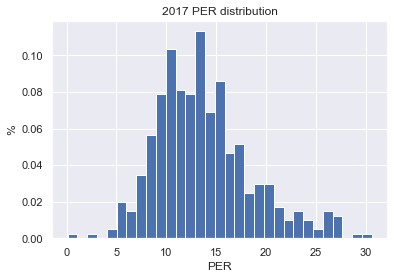

In [12]:
plt.hist(df['PER'], bins=31, density=True)
plt.xlabel('PER')
plt.ylabel('%')
plt.title(f'{year} PER distribution')
plt.show()

In [13]:
max_per = df[df['PER'] == df['PER'].max()].squeeze()
print('Player with maximum PER for year {} is {} with PER of {}'.format(year, max_per['Player'], max_per['PER']))
print ('MVP for year {} is {}'.format(year, mvp_dict[year]))

Player with maximum PER for year 2017 is Russell Westbrook with PER of 30.6
MVP for year 2017 is Russell Westbrook


In [14]:
max_per

Player    Russell Westbrook
Pos                      PG
Age                      28
Tm                      OKC
G                        81
MP                     2802
PER                    30.6
TS%                   0.554
3PAr                    0.3
FTr                   0.433
ORB%                    5.4
DRB%                   28.8
TRB%                   17.1
AST%                   57.3
STL%                    2.3
BLK%                    0.9
TOV%                   15.9
USG%                   41.7
OWS                     8.5
DWS                     4.6
WS                     13.1
WS/48                 0.224
OBPM                    8.7
DBPM                    2.4
BPM                    11.1
VORP                    9.3
Name: 457, dtype: object

Now we will split the data to positions to see if there is any diffrence

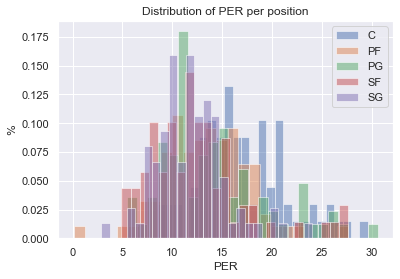

In [15]:
for i,p in enumerate(unique_pos):
    plt.hist(df[df['Pos']==p]['PER'], alpha=0.5, label=p, bins=25, density=True, color=current_palette[i])
plt.xlabel('PER')
plt.ylabel('%')
plt.title('Distribution of PER per position')
plt.legend()
plt.show()

Assuming Normal distrebution - let's find the $\Theta=(\mu , \sigma)$ parameters for each position

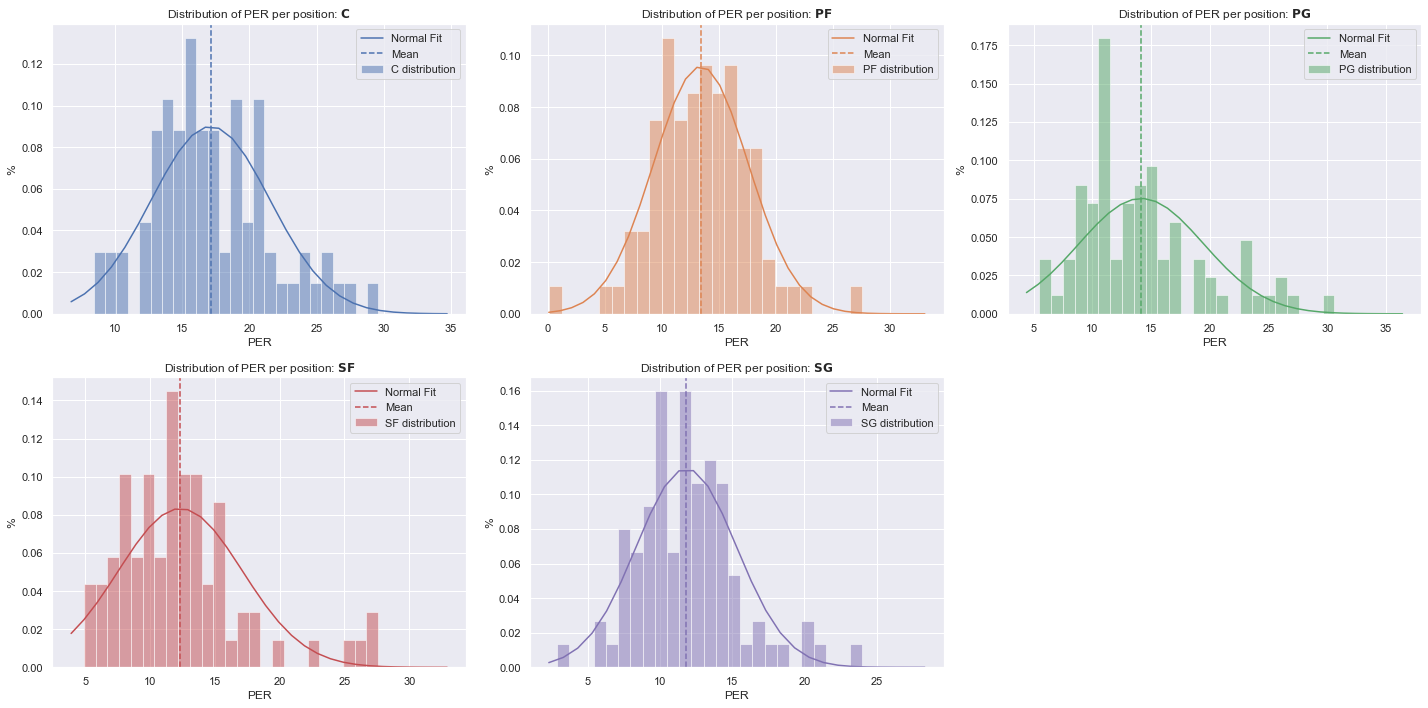

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i,p in enumerate(unique_pos):
    d = df[df['Pos']==p]['PER']
    x_axis = np.arange(np.min(d)*0.8, np.max(d)*1.2, 1)
    ax = axes[i//3][i%3]
    ax.plot(x_axis, scipy.stats.norm.pdf(x_axis,np.mean(d),np.std(d)), color=current_palette[i], label='Normal Fit')
    ax.hist(d, alpha=0.5, label=f'{p} distribution', bins=25, density=True, color=current_palette[i])
    ax.axvline(d.mean(), linestyle='--', color=current_palette[i], label='Mean')
    ax.legend()
    ax.set_xlabel('PER')
    ax.set_ylabel('%')
    ax.set_title(f'Distribution of PER per position: ' + r"$\bf{" + p + "}$")
    
axes[-1, -1].axis('off')
fig.tight_layout()
plt.show()


We can see from the plots above that the PER is now distributed the same accross all positions!!

OK... So that means that MVP should be the player that was performing best in his position.

We can start with taking the naive approach and see which is the player that is far from the mean value of the performances within the rest of the players in his position

In [17]:
def std_dist(per, mean_per, std_per):
    return (per-mean_per)/std_per

In [18]:
print (f"\033[4mYear: {year}\033[0m")
max_per_pos_dict = {}
for i,p in enumerate(unique_pos):
    pos_df = df[df['Pos']==p]
    max_per = pos_df[pos_df['PER'] == pos_df['PER'].max()].squeeze()
    std_d = std_dist(max_per['PER'].squeeze(), np.mean(pos_df['PER']).squeeze(), np.std(pos_df['PER']).squeeze())
    #TODO: Fix these sueezes
    print (f'For position {p}:')
    print (f"Player with maximum PER within position is {max_per['Player']} with PER = {max_per['PER']}")
    print (f'Which is \033[1m{std_d:.2f}σ\033[0m far from mean value')
    max_per_pos_dict[p] = max_per

Year: 2017
For position C:
Player with maximum PER within position is Boban Marjanović with PER = 29.6
Which is 2.82σ far from mean value
For position PF:
Player with maximum PER within position is Kevin Durant with PER = 27.6
Which is 3.40σ far from mean value
For position PG:
Player with maximum PER within position is Russell Westbrook with PER = 30.6
Which is 3.10σ far from mean value
For position SF:
Player with maximum PER within position is Kawhi Leonard with PER = 27.6
Which is 3.19σ far from mean value
For position SG:
Player with maximum PER within position is DeMar DeRozan with PER = 24.0
Which is 3.50σ far from mean value


That is just.... Wow!

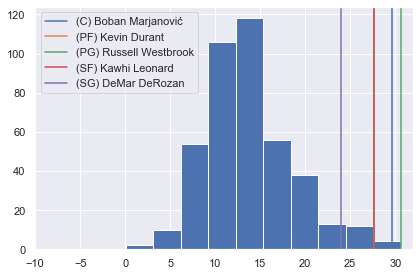

In [19]:
plt.hist(df['PER'])
for i,(k,v) in enumerate(max_per_pos_dict.items()):
    plt.axvline(v['PER'], color=current_palette[i], label=f"({k}) {v['Player']}")
# fig = plt.figure(figsize=(18, 18))
plt.xlim(-10,32)
plt.tight_layout()
plt.legend()
plt.show()

## Creat a model for estimating the true distribtion per position

Fetch data and create database that contains only the players, position, PER, year, is_MVP

In [20]:
years_range=(2005,2020)

In [21]:
db = data_fetcher.create_database(years_range)

In [22]:
db.head(5)

,Player,Pos,PER,Year,MVP
0,Shareef Abdur-Rahim,PF,18.7,2005,False
1,Malik Allen,PF,14.2,2005,False
2,Ray Allen,SG,20.9,2005,False
3,Tony Allen,SG,14.7,2005,False
4,Rafer Alston,PG,16.5,2005,False


Calulate the global mean and std

In [23]:
μ_global = db['PER'].mean()
σ_global = db['PER'].std()
print (f'Global PER (accross all years - all players):\nμ_global = {μ_global:.2f}\nσ_global = {σ_global:.2f}')

Global PER (accross all years - all players):
μ_global = 13.61
σ_global = 4.55


In [24]:
def calc_per_mean_per_pos(pos, db):
    return db[db['Pos']==pos]['PER'].mean()

In [25]:
def calc_per_std_per_pos(pos, db):
    return db[db['Pos']==pos]['PER'].std()

In [26]:
μ_years_range = {pos:calc_per_mean_per_pos(pos, db) for pos in unique_pos}
σ_years_range = {pos:calc_per_std_per_pos(pos, db) for pos in unique_pos}

In [27]:
μ_years_range, σ_years_range

({'C': 14.91324717285945,
  'PF': 14.158870967741935,
  'PG': 13.75198312236287,
  'SF': 12.583109919571045,
  'SG': 12.575688434303698},
 {'C': 4.84200853805433,
  'PF': 4.421358610284668,
  'PG': 4.448914026279718,
  'SF': 4.349604754264269,
  'SG': 4.192445283931073})

Example of pos=='SG'

In [28]:
year

2017

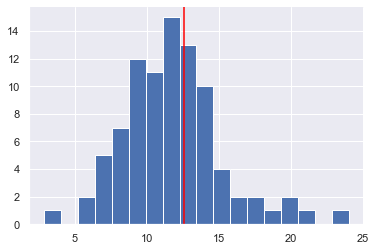

In [29]:
pos='SG'
one_pos_one_year_d = db['PER'][(db['Pos']==pos) & (db['Year']==year)]
plt.hist(one_pos_one_year_d, bins=18)
plt.axvline(μ_years_range[pos], color='red')
sns.despine()
plt.show()

Let's start with estimating the $\mu$ parameter while assuming $\sigma$ is constant

In [30]:
def log_likelihood(θ, X):
    μ, σ = θ
    return scipy.stats.norm(μ, σ).logpdf(X).sum()

In [31]:
def log_prior_2d_uni(μ):
    if μ > 0:
        return 0
    else:
        return -np.inf
    
def log_posterior_2d_uni(μ, X):
    pri = log_prior_2d_uni(μ)
    if np.isinf(pri): 
        return pri
    return pri + log_likelihood((μ, σ_global), X)

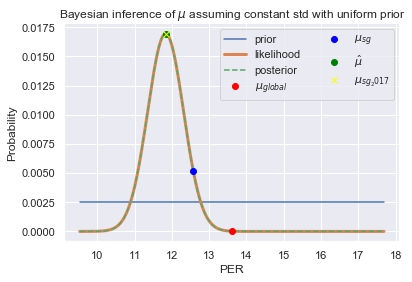

In [54]:
μ_range = np.linspace(μ_global*0.70, μ_global*1.3, 400)

pri = np.exp([log_prior_2d_uni(μ_) for μ_ in μ_range])
lik = np.exp([log_likelihood((μ_, σ_global), one_pos_one_year_d) for μ_ in μ_range])
post = np.exp([log_posterior_2d_uni(μ_, one_pos_one_year_d) for μ_ in μ_range])

μ_hat = μ_range[post.argmax()] # MAP

plt.plot(μ_range, pri/pri.sum(), label='prior')
plt.plot(μ_range, lik/lik.sum(), lw=3, label='likelihood')
plt.plot(μ_range, post/post.sum(), ls='--', label='posterior')

plt.plot(μ_global, np.exp(log_posterior_2d_uni(μ_global, one_pos_one_year_d))/post.sum(), 'o', color='red', label='$μ_{global}$')
plt.plot(μ_years_range[pos], np.exp(log_posterior_2d_uni(μ_years_range[pos], one_pos_one_year_d))/post.sum(), 'o', color='blue', label='$μ_{'+pos.lower()+'}$')
plt.plot(μ_hat, np.exp(log_posterior_2d_uni(μ_hat, one_pos_one_year_d))/post.sum(), 'o', color='green', label='$\hat{μ}$')
plt.plot(one_pos_one_year_d.mean(), np.exp(log_posterior_2d_uni(one_pos_one_year_d.mean(), one_pos_one_year_d))/post.sum(), 'x', color='yellow', label='$μ_{'+pos.lower()+'_'+str(year)+'}$')

plt.xlabel("PER")
plt.ylabel("Probability")
plt.title(f'Bayesian inference of $\mu$ assuming constant std with uniform prior')
plt.legend(ncol=2)
sns.despine()

We can see that the $\mu_{global}$ which refers to the data accross all positions, all years are not aligned well with the posterior, but the mean value for the same position across all years looks closer

Now let's find better prior. Becasue we already saw that the data is distributed normaly, we can assume ~$N(\mu_{global},1)$

In [65]:
def log_prior_2d_norm(μ):
    if μ > 0:
        return scipy.stats.norm(μ_global, 1).logpdf(μ)
    else:
        return -np.inf
    
def log_posterior_2d_norm(μ, X):
    pri = log_prior_2d_norm(μ)
    if np.isinf(pri): 
        return pri
    return pri + log_likelihood((μ, σ_global), X)

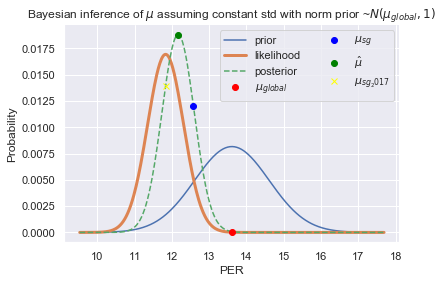

In [68]:
μ_range = np.linspace(μ_global*0.70, μ_global*1.3, 400)

pri = np.exp([log_prior_2d_norm(μ_) for μ_ in μ_range])
lik = np.exp([log_likelihood((μ_, σ_global), one_pos_one_year_d) for μ_ in μ_range])
post = np.exp([log_posterior_2d_norm(μ_, one_pos_one_year_d) for μ_ in μ_range])

μ_hat = μ_range[post.argmax()] # MAP

plt.plot(μ_range, pri/pri.sum(), label='prior')
plt.plot(μ_range, lik/lik.sum(), lw=3, label='likelihood')
plt.plot(μ_range, post/post.sum(), ls='--', label='posterior')

plt.plot(μ_global, np.exp(log_posterior_2d_norm(μ_global, one_pos_one_year_d))/post.sum(), 'o', color='red', label='$μ_{global}$')
plt.plot(μ_years_range[pos], np.exp(log_posterior_2d_norm(μ_years_range[pos], one_pos_one_year_d))/post.sum(), 'o', color='blue', label='$μ_{'+pos.lower()+'}$')
plt.plot(μ_hat, np.exp(log_posterior_2d_norm(μ_hat, one_pos_one_year_d))/post.sum(), 'o', color='green', label='$\hat{μ}$')
plt.plot(one_pos_one_year_d.mean(), np.exp(log_posterior_2d_norm(one_pos_one_year_d.mean(), one_pos_one_year_d))/post.sum(), 'x', color='yellow', label='$μ_{'+pos.lower()+'_'+str(year)+'}$')

plt.xlabel("PER")
plt.ylabel("Probability")
plt.title('Bayesian inference of $\mu$ assuming constant std with norm prior ~$N(\mu_{global},1)$')
plt.legend(ncol=2)
sns.despine()

Now let's change the prior for our mean per position

In [113]:
def log_prior_2d_norm(μ):
    if μ > 0:
        return scipy.stats.norm(μ_years_range[pos], 1).logpdf(μ)
    else:
        return -np.inf
    
def log_posterior_2d_norm(μ, X):
    pri = log_prior_2d_norm(μ)
    if np.isinf(pri): 
        return pri
    return pri + log_likelihood((μ, σ_global), X)

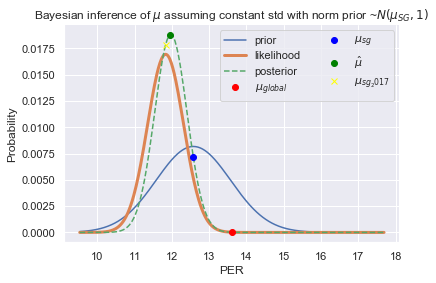

In [76]:
μ_range = np.linspace(μ_global*0.70, μ_global*1.3, 400)

pri = np.exp([log_prior_2d_norm(μ_) for μ_ in μ_range])
lik = np.exp([log_likelihood((μ_, σ_global), one_pos_one_year_d) for μ_ in μ_range])
post = np.exp([log_posterior_2d_norm(μ_, one_pos_one_year_d) for μ_ in μ_range])

μ_hat = μ_range[post.argmax()] # MAP

plt.plot(μ_range, pri/pri.sum(), label='prior')
plt.plot(μ_range, lik/lik.sum(), lw=3, label='likelihood')
plt.plot(μ_range, post/post.sum(), ls='--', label='posterior')

plt.plot(μ_global, np.exp(log_posterior_2d_norm(μ_global, one_pos_one_year_d))/post.sum(), 'o', color='red', label='$μ_{global}$')
plt.plot(μ_years_range[pos], np.exp(log_posterior_2d_norm(μ_years_range[pos], one_pos_one_year_d))/post.sum(), 'o', color='blue', label='$μ_{'+pos.lower()+'}$')
plt.plot(μ_hat, np.exp(log_posterior_2d_norm(μ_hat, one_pos_one_year_d))/post.sum(), 'o', color='green', label='$\hat{μ}$')
plt.plot(one_pos_one_year_d.mean(), np.exp(log_posterior_2d_norm(one_pos_one_year_d.mean(), one_pos_one_year_d))/post.sum(), 'x', color='yellow', label='$μ_{'+pos.lower()+'_'+str(year)+'}$')

plt.xlabel("PER")
plt.ylabel("Probability")
plt.title(f'Bayesian inference of $\mu$ assuming constant std with norm prior ~$N(\mu_{{{pos}}},1)$')
plt.legend(ncol=2)
sns.despine()

The real data (yellow) fits better

Now let make it more complicated, we will try to estimate both the $\mu$ and the $\sigma$. Starting woth uniform prior

In [ ]:
# Becasue we will need to run these function accross all grid, we will C++ compile them
@numba.jit(forceobj=True)
def log_likelihood(θ, X):
    μ, σ = θ
    return scipy.stats.norm(μ, σ).logpdf(X).sum()

In [144]:
@numba.jit(forceobj=True)
def log_prior_3d_uni(θ):
    μ, σ = θ
    if μ > 0 and σ > 0:
        return 0
    else:
        return (-np.inf)
    
@numba.jit(forceobj=True)    
def log_posterior_3d_uni(θ, X):
    pri = log_prior_3d_uni(θ)
    if np.isinf(pri): 
        return pri
    return pri + log_likelihood(θ, X)

In [150]:
μ_range = np.linspace(μ_global*0.70, μ_global*1.3, 100)
σ_range = np.linspace(σ_global*0.60, σ_global*1.4, 100)

X, Y = np.meshgrid(μ_range, σ_range)

In [151]:
pri_grid_uni = np.empty([len(μ_range), len(σ_range)])
lik_grid_uni = np.empty([len(μ_range), len(σ_range)])
post_grid_uni = np.empty([len(μ_range), len(σ_range)])

for μi, μ_ in enumerate(μ_range):
    for σi, σ_ in enumerate(σ_range):
        pri_grid_uni[σi][μi] = np.exp(log_prior_3d_uni((μ_, σ_)))
        lik_grid_uni[σi][μi] = np.exp(log_likelihood((μ_, σ_), one_pos_one_year_d))
        post_grid_uni[σi][μi] = np.exp(log_posterior_3d_uni((μ_, σ_), one_pos_one_year_d))

In [179]:
σ_hat_idx, μ_hat_idx = np.unravel_index(post_grid_uni.argmax(), post_grid_uni.shape)
μ_hat, σ_hat = μ_range[μ_hat_idx], σ_range[σ_hat_idx]
μ_pos, σ_pos = one_pos_one_year_d.mean(), one_pos_one_year_d.std()

μ_hat x σ_hat cordinates = (11.8364, 3.4637, 0.004907)
μ_pos x σ_pos coordinates = (11.8315, 3.4933, 0.004897)


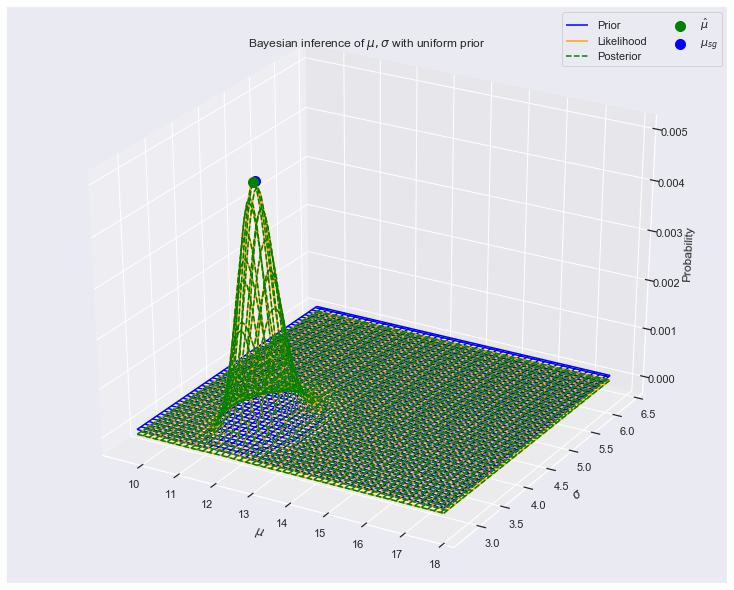

In [182]:
fig = plt.figure(figsize=((10,8)))
ax = Axes3D(fig)
ax.plot_wireframe(X, Y, (pri_grid_uni/pri_grid_uni.sum()),  color='blue', label='Prior')
ax.plot_wireframe(X, Y, (lik_grid_uni/lik_grid_uni.sum()),  color='orange', label='Likelihood')
ax.plot_wireframe(X, Y, (post_grid_uni/post_grid_uni.sum()), color='green', linestyle='--', label='Posterior')

ax.scatter([μ_hat], [σ_hat], [np.exp(log_posterior_3d_uni((μ_hat, σ_hat), one_pos_one_year_d))/post_grid_uni.sum()], s=100, color='green', label='$\hat{μ}$')
ax.scatter([μ_pos], [σ_pos], [np.exp(log_posterior_3d_uni((μ_pos, σ_pos), one_pos_one_year_d))/post_grid_uni.sum()], s=100, color='blue', label='$μ_{'+pos.lower()+'}$')

ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_zlabel('Probability')
ax.set_title(f'Bayesian inference of $\mu,\sigma$ with uniform prior')

ax.legend(ncol=2)

plt.show()

In [195]:
print (f'μ_hat x σ_hat cordinates = ({μ_hat:.4f}, {σ_hat:.4f}, {np.exp(log_posterior_3d_uni((μ_hat, σ_hat), one_pos_one_year_d))/post_grid_uni.sum():.6f})')
print (f'μ_pos x σ_pos coordinates = ({μ_pos:.4f}, {σ_pos:.4f}, {np.exp(log_posterior_3d_uni((μ_pos, σ_pos), one_pos_one_year_d))/post_grid_uni.sum():.6f})')


μ_hat x σ_hat cordinates = (11.8364, 3.4637, 0.004907)
μ_pos x σ_pos coordinates = (11.8315, 3.4933, 0.004897)


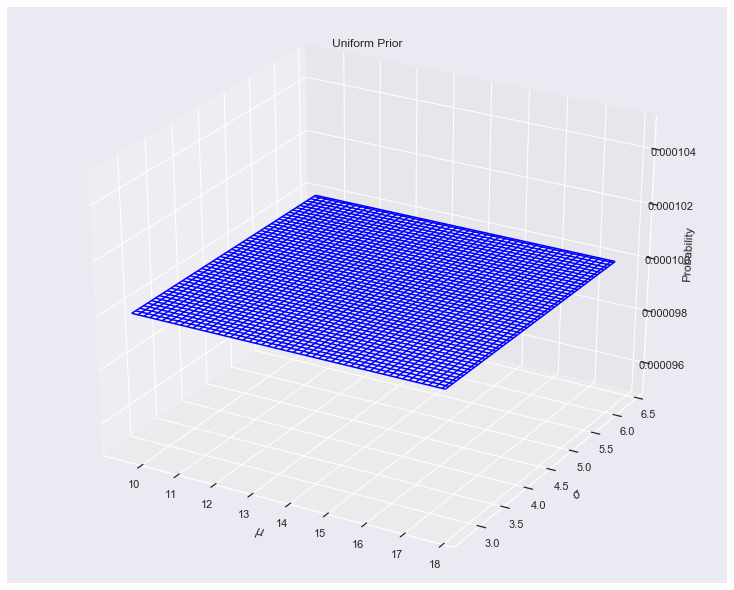

In [183]:
fig = plt.figure(figsize=((10,8)))
ax = Axes3D(fig)
ax.plot_wireframe(X, Y, (pri_grid_uni/pri_grid_uni.sum()),  color='blue', label='Prior')
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_zlabel('Probability')
ax.set_title('Uniform Prior')
plt.show()

$\mu$ position looks very close to the max likelihood which is close to the maximum posterior. Let's take it one more step with normal prior $\mu$ ~ $N(\mu_{global},1)$ and  $\sigma$ ~ $N(\sigma_{global}, 1)$. That will give us better estimation with regards to the player against the overall players

In [224]:
np.cov([db['PER'][db['Year']==y].mean() for y in range(*years_range)], [db['PER'][db['Year']==y].std() for y in range(*years_range)])

array([[0.05900547, 0.012791  ],
       [0.012791  , 0.02455787]])

In [221]:
rangyears_range

(2005, 2020)

In [209]:
#TODO covarience

@numba.jit(forceobj=True)
def log_prior_3d_norm(θ):
    μ, σ = θ
    if μ > 0 and σ > 0:
        #return scipy.stats.norm(μ_years_range[pos], 1).logpdf(μ) + scipy.stats.norm(σ_years_range[pos], 1).logpdf(σ)
        return scipy.stats.norm(μ_global, 1).logpdf(μ) + scipy.stats.norm(σ_global, 1).logpdf(σ)
    else:
        return -np.inf

@numba.jit(forceobj=True)
def log_posterior_3d_norm(θ, X):
    pri = log_prior_3d_norm(θ)
    if np.isinf(pri): 
        return pri
    return pri + log_likelihood(θ, X)

In [210]:
pri_grid_norm = np.empty([len(μ_range), len(σ_range)])
lik_grid_norm = np.empty([len(μ_range), len(σ_range)])
post_grid_norm = np.empty([len(μ_range), len(σ_range)])

for μi, μ_ in enumerate(μ_range):
    for σi, σ_ in enumerate(σ_range):
        pri_grid_norm[σi][μi] = np.exp(log_prior_3d_norm((μ_, σ_)))
        lik_grid_norm[σi][μi] = np.exp(log_likelihood((μ_, σ_), one_pos_one_year_d))
        post_grid_norm[σi][μi] = np.exp(log_posterior_3d_norm((μ_, σ_), one_pos_one_year_d))

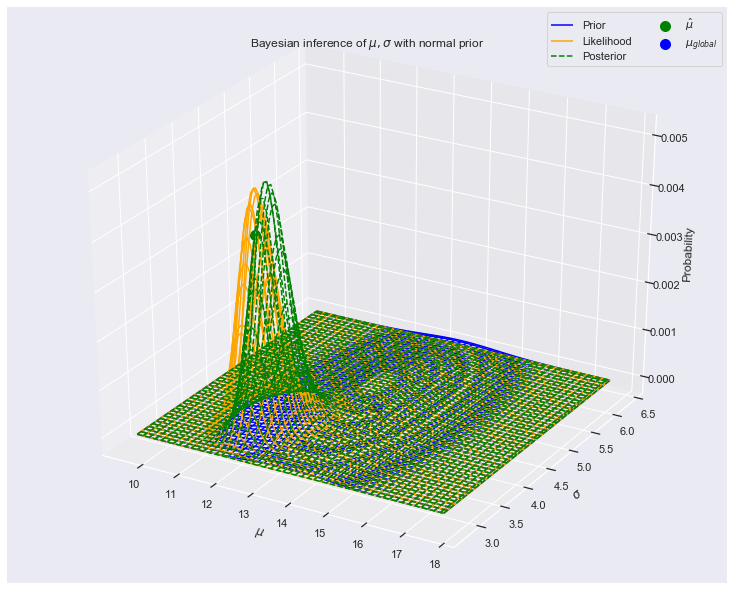

In [212]:
fig = plt.figure(figsize=((10,8)))
ax = Axes3D(fig)
ax.plot_wireframe(X, Y, (pri_grid_norm/pri_grid_norm.sum()),  color='blue', label='Prior')
ax.plot_wireframe(X, Y, (lik_grid_norm/lik_grid_norm.sum()),  color='orange', label='Likelihood')
ax.plot_wireframe(X, Y, (post_grid_norm/post_grid_norm.sum()), color='green', linestyle='--', label='Posterior')

ax.scatter([μ_hat], [σ_hat], [np.exp(log_posterior_3d_norm((μ_hat, σ_hat), one_pos_one_year_d))/post_grid_norm.sum()], s=100, color='green', label='$\hat{μ}$')
#ax.scatter([μ_pos], [σ_pos], [np.exp(log_posterior_3d_norm((μ_pos, σ_pos), one_pos_one_year_d))/post_grid_norm.sum()], s=100, color='blue', label='$μ_{'+pos.lower()+'}$')
ax.scatter([μ_global], [σ_global], [np.exp(log_posterior_3d_norm((μ_global, σ_global), one_pos_one_year_d))/post_grid_norm.sum()], s=100, color='blue', label='$μ_{global}$')

ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_zlabel('Probability')
ax.set_title(f'Bayesian inference of $\mu,\sigma$ with normal prior')

ax.legend(ncol=2)

plt.show()

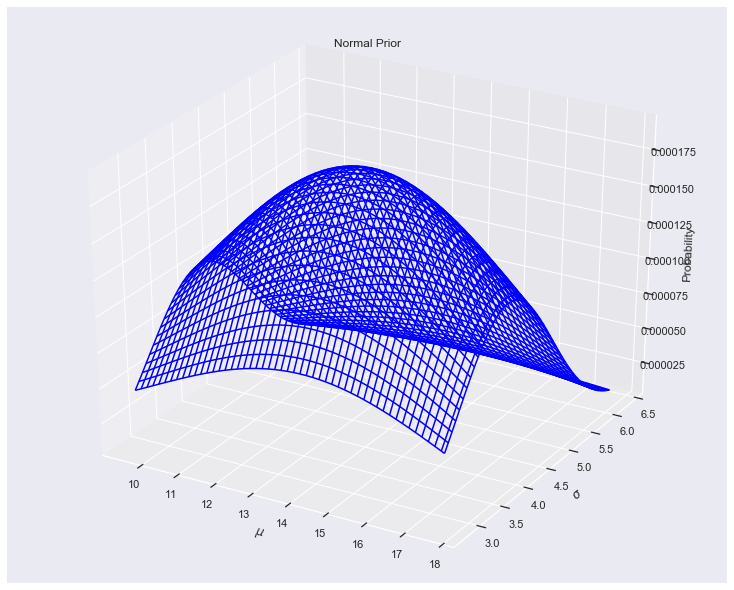

In [208]:
fig = plt.figure(figsize=((10,8)))
ax = Axes3D(fig)
ax.plot_wireframe(X, Y, (pri_grid_norm/pri_grid_norm.sum()),  color='blue', label='Prior')

ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_zlabel('Probability')
ax.set_title(f'Normal Prior')

plt.show()

In [214]:
print (f'μ_hat x σ_hat cordinates = ({μ_hat:.4f}, {σ_hat:.4f}, {np.exp(log_posterior_3d_norm((μ_hat, σ_hat), one_pos_one_year_d))/post_grid_norm.sum():.6f})')
print (f'μ_pos x σ_pos coordinates = ({μ_pos:.4f}, {σ_pos:.4f}, {np.exp(log_posterior_3d_norm((μ_pos, σ_pos), one_pos_one_year_d))/post_grid_norm.sum():.6f})')
print (f'μ_global x σ_global coordinates = ({μ_global:.4f}, {σ_global:.4f}, {np.exp(log_posterior_3d_norm((μ_global, σ_global), one_pos_one_year_d))/post_grid_norm.sum():.8f})')



μ_hat x σ_hat cordinates = (11.8364, 3.4637, 0.003994)
μ_pos x σ_pos coordinates = (11.8315, 3.4933, 0.004078)
μ_global x σ_global coordinates = (13.6098, 4.5478, 0.00000017)


In [27]:
# def log_prior_uni(θ):
#     μ, σ = θ
#     if μ > 0 and σ > 0:
#         return 0
#     else:
#         return -np.inf
    
# def log_posterior_uni(θ, X):
#     pri = log_prior_uni(θ)
#     if np.isinf(pri): 
#         return pri
#     return pri + log_likelihood(θ, X)

In [126]:
#TODO: Do 3D MLE
# μ = μ_years_range[pos]
# σ = σ_years_range[pos]
# μ_MLE = one_pos_one_year_d.mean()
# σ_MLE = one_pos_one_year_d.std()
# print("μ = {:.2f} \nμ_MLE = {:.2f}".format(μ, μ_MLE))
# print("σ = {:.2f} \nσ_MLE = {:.2f}".format(σ, σ_MLE))

μ = 12.58 
μ_MLE = 11.83
σ = 4.19 
σ_MLE = 3.49


In [30]:
# def plot_pri_post_like(X, μ, σ, log_prior, log_likelihood, log_posterior):
# #     μ_hat = X.mean()
# #     σ_hat = X.std()
#     μ_range = np.linspace(μ*0.70, μ*1.3, 400)
#     pri = np.exp([log_prior(μ_) for μ_ in μ_range])
#     lik = np.exp([log_likelihood(μ_, σ, X) for μ_ in μ_range])
#     post = np.exp([log_posterior(μ_, σ, X) for μ_ in μ_range])
#     μ_hat = μ_range[post.argmax()] # maximum a posterioi estimate
#     print("μ = {} \nμ_hat = {:.2f}".format(μ, μ_hat))
#     plt.plot(μ_range, pri/pri.sum(), label='prior')
#     plt.plot(μ_range, lik/lik.sum(), lw=3, label='likelihood')
#     plt.plot(μ_range, post/post.sum(), ls='--', label='posterior')
#     plt.plot(μ, np.exp(log_posterior(μ, σ, X))/post.sum(), 'o', color='red', label='$μ$')
#     plt.plot(μ_hat, np.exp(log_posterior(μ_hat, σ_hat, X))/post.sum(), 'o', color='green', label='$\hat{μ}$')

#     plt.xlabel("PER")
#     plt.ylabel("Probability")
#     plt.yscale("log")
#     plt.legend(ncol=2)
#     sns.despine()

In [129]:
# from mpl_toolkits.mplot3d import Axes3D

In [147]:
# μ_range = np.linspace(μ*0.70, μ*1.3, 100)
# σ_range = np.linspace(σ*0.80, σ*1.2, 100)

# X, Y = np.meshgrid(μ_range, σ_range)

In [148]:
# Create grid and calc prior, likelihood and posterior for each
# μ_range = np.linspace(μ*0.8, μ*1.2, 100)
# σ_range = np.linspace(σ*0.7, σ*1.3, 100)

# X, Y = np.meshgrid(μ_range, σ_range)

# pri_grid_uni = np.empty([len(μ_range), len(σ_range)])
# lik_grid_uni = np.empty([len(μ_range), len(σ_range)])
# post_grid_uni = np.empty([len(μ_range), len(σ_range)])

# for μi, μ_ in enumerate(μ_range):
#     for σi, σ_ in enumerate(σ_range):
#         pri_grid_uni[σi][μi] = np.exp(log_prior_uni((μ_, σ_)))
#         lik_grid_uni[σi][μi] = np.exp(log_likelihood((μ_, σ_), one_pos_one_year_d))
#         post_grid_uni[σi][μi] = np.exp(log_posterior_uni((μ_, σ_), one_pos_one_year_d))




In [149]:
# %matplotlib notebook

In [150]:
# print (f'μ x σ cordinates = ({μ:.2f}, {σ:.2f}, {np.exp(log_posterior_uni((μ, σ), one_pos_one_year_d))/post_grid_uni.sum():.5f})')

# σ_hat_idx, μ_hat_idx = np.unravel_index(post_grid_uni.argmax(), post_grid_uni.shape)
# μ_hat, σ_hat = μ_range[μ_hat_idx], σ_range[σ_hat_idx]
# print (f'μ_hat x σ_hat cordinates = ({μ_hat:.2f}, {σ_hat:.2f}, {np.exp(log_posterior_uni((μ_hat, σ_hat), one_pos_one_year_d))/post_grid_uni.sum():.7f})')




μ x σ cordinates = (12.58, 4.19, 0.00003)
μ_hat x σ_hat cordinates = (11.84, 3.47, 0.0020992)


In [151]:
# ppp = post_grid_uni.max()/post_grid_uni.sum()
# ppp

0.0020991836422514804

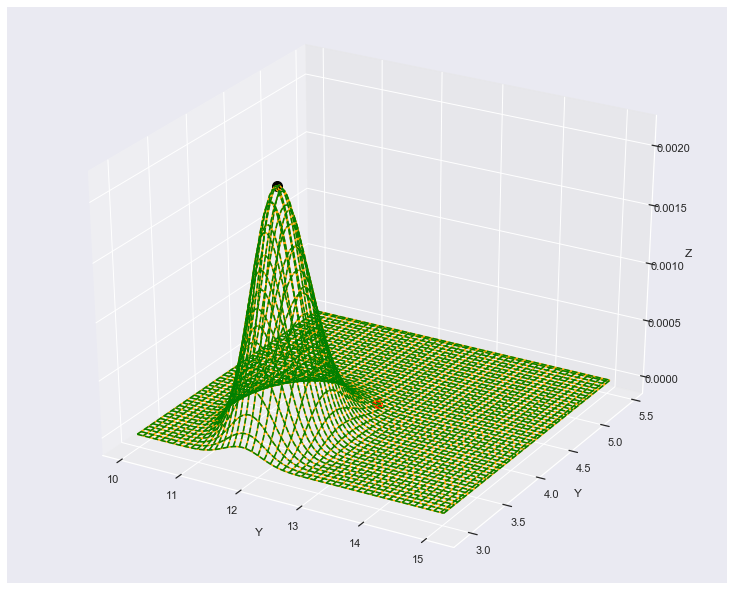

In [152]:
# fig = plt.figure(figsize=((10,8)))
# ax = Axes3D(fig)
# ax.plot_wireframe(X, Y, (lik_grid_uni/lik_grid_uni.sum()),  color='orange', label='Likelihood')
# ax.plot_wireframe(X, Y, (post_grid_uni/post_grid_uni.sum()), color='green', linestyle='--', label='Posterior')

# ax.scatter([μ_hat], [σ_hat], [np.exp(log_posterior_uni((μ_hat, σ_hat), one_pos_one_year_d))/post_grid_uni.sum()], s=100, color='black', label='$\hat{μ}$')
# ax.scatter([μ], [σ], [np.exp(log_posterior_uni((μ, σ), one_pos_one_year_d))/post_grid_uni.sum()], color='red', s=100, label='$μ$')

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# # ax.zaxis._set_scale('log')
# # ax.yaxis.set_scale('log').yaxis.set_scale('log')
# # ax.zaxis._set_scale('log')
# plt.show()


Assuming independent $\sigma$ and $\mu$

In [119]:

# log_pr = scipy.stats.norm(14, 4).logpdf(11.83) + scipy.stats.norm(4, 1).logpdf(3.5)




In [112]:
# TODO: Try and add covariance compensation
# def log_prior_norm(θ):
#     μ, σ = θ
#     if μ > 0 and σ > 0:
#         return scipy.stats.norm(14, 4).logpdf(μ) + scipy.stats.norm(4, 1).logpdf(σ)
#     else:
#         return -np.inf

In [113]:
# def log_posterior_norm(θ, X):
#     pri = log_prior_norm(θ)
#     if np.isinf(pri): 
#         return pri
#     return pri + log_likelihood(θ, X)

In [143]:
# Create grid and calc prior, likelihood and posterior for each
# μ_range = np.linspace(μ*0.8, μ*1.2, 100)
# σ_range = np.linspace(σ*0.7, σ*1.3, 100)

# X, Y = np.meshgrid(μ_range, σ_range)

# pri_grid_norm = np.empty([len(μ_range), len(σ_range)])
# lik_grid_norm = np.empty([len(μ_range), len(σ_range)])
# post_grid_norm = np.empty([len(μ_range), len(σ_range)])

# #TODO: make this function more efficient
# for μi, μ_ in enumerate(μ_range):
#     for σi, σ_ in enumerate(σ_range):
#         pri_grid_norm[σi][μi] = np.exp(log_prior_norm((μ_, σ_)))
#         lik_grid_norm[σi][μi] = np.exp(log_likelihood((μ_, σ_), one_pos_one_year_d))
#         post_grid_norm[σi][μi] = np.exp(log_posterior_norm((μ_, σ_), one_pos_one_year_d))

In [144]:
# print (f'μ x σ cordinates = ({μ:.2f}, {σ:.2f}, {np.exp(log_posterior_norm((μ, σ), one_pos_one_year_d))/post_grid_norm.sum():.5f})')

# σ_hat_idx, μ_hat_idx = np.unravel_index(post_grid_norm.argmax(), post_grid_norm.shape)
# μ_hat, σ_hat = μ_range[μ_hat_idx], σ_range[σ_hat_idx]
# print (f'μ_hat x σ_hat cordinates = ({μ_hat:.2f}, {σ_hat:.2f}, {np.exp(log_posterior_norm((μ_hat, σ_hat), one_pos_one_year_d))/post_grid_norm.sum():.7f})')




μ x σ cordinates = (12.58, 4.19, 0.00022)
μ_hat x σ_hat cordinates = (12.45, 3.52, 0.0021013)


μ_hat x σ_hat cordinates = (12.45, 3.52, 0.00053)
μ x σ cordinates = (12.58, 4.19, 0.00003)


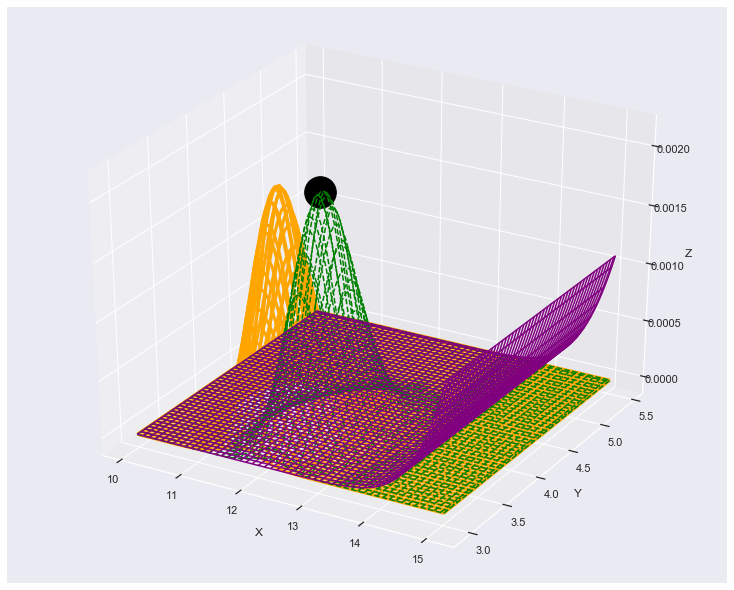

In [145]:
#TODO: Plot one plot with only prior

print (f'μ_hat x σ_hat cordinates = ({μ_hat:.2f}, {σ_hat:.2f}, {np.exp(log_posterior_uni((μ_hat, σ_hat), one_pos_one_year_d))/post_grid_uni.sum():.5f})')
print (f'μ x σ cordinates = ({μ:.2f}, {σ:.2f}, {np.exp(log_posterior_uni((μ, σ), one_pos_one_year_d))/post_grid_uni.sum():.5f})')
# print (f'Max likelihood = {max(np.exp(log_posterior_norm((μ_hat, σ_hat), one_pos_one_year_d))/post_grid_norm.sum())}')

fig = plt.figure(figsize=((10,8)))
ax = Axes3D(fig)

ax.plot_wireframe(X, Y, (lik_grid_norm/lik_grid_norm.sum()),  lw=3, color='orange')
ax.plot_wireframe(X, Y, (post_grid_norm/post_grid_norm.sum()), color='green', linestyle='--')
ax.plot_wireframe(X, Y, (pri_grid_norm/pri_grid_norm.sum()),  color='purple')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.scatter([μ_hat], [σ_hat], [np.exp(log_posterior_norm((μ_hat, σ_hat), one_pos_one_year_d))/post_grid_norm.sum()], s=1000, color='black', label='$\hat{μ}$')
ax.scatter([μ], [σ], [np.exp(log_posterior_norm((μ, σ), one_pos_one_year_d))/post_grid_norm.sum()], color='red', s=1000)
# ax.scatter(m[i,0],m[i,1],m[i,2],color='b') 
# ax.scatter([μ_hat], [σ_hat], [np.exp(log_posterior_uni((μ_hat, σ_hat), one_pos_one_year_d))/post_grid.sum()], s=1000, color='red')
# ax.scatter([μ], [σ], [np.exp(log_posterior_uni((μ, σ), one_pos_one_year_d))/post_grid.sum()], color='black', s=1000)
# ax.zaxis._set_scale('log')
# ax.yaxis.set_scale('log').yaxis.set_scale('log')
plt.show()

In [95]:
np.exp(log_posterior_norm((μ_hat, σ_hat), one_pos_one_year_d))/post_grid_norm.sum()

0.0016720188272567856

In [97]:
log_posterior_norm((μ_hat, σ_hat), one_pos_one_year_d)

-241.42742097609795

In [100]:
np.unravel_index(b.argmax(), b.shape)

(23, 40)

In [111]:
μ_range[35], σ_range[23]

(11.838930930071765, 3.5191131625724457)

In [107]:
X[23][40], Y[23][40]

(12.09298524187588, 3.5191131625724457)

In [40]:
a=lik_grid_norm/lik_grid_norm.sum()

In [41]:
a.max()

0.0020991836422514804

In [42]:
np.unravel_index(a.argmax(), a.shape)

(21, 35)

Now we will change the prior to Norm

In [52]:
def plot_pri_post_like(X, μ, σ, log_prior, log_likelihood, log_posterior):
#     μ_hat = X.mean()
#     σ_hat = X.std()
    μ_range = np.linspace(μ*0.70, μ*1.3, 400)
    pri = np.exp([log_prior((μ_, σ)) for μ_ in μ_range])
    lik = np.exp([log_likelihood((μ_, σ), X) for μ_ in μ_range])
    post = np.exp([log_posterior((μ_, σ), X) for μ_ in μ_range])
    μ_hat = μ_range[post.argmax()] # maximum a posterioi estimate
    
    plt.plot(μ_range, pri/pri.sum(), label='prior')
    plt.plot(μ_range, lik/lik.sum(), lw=3, label='likelihood')
    plt.plot(μ_range, post/post.sum(), ls='--', label='posterior')
    plt.plot(μ, np.exp(log_posterior((μ, σ), X))/post.sum(), 'o', color='red', label='$μ$')
    #plt.plot(μ_hat, np.exp(log_posterior((μ_hat, σ_hat), X))/post.sum(), 'o', color='green', label='$\hat{μ}$')
    plt.plot(μ_hat, np.exp(log_posterior((μ_hat, σ), X))/post.sum(), 'o', color='green', label='$\hat{μ}$')

    plt.xlabel("PER")
    plt.ylabel("Probability")
#     plt.yscale("log")
    plt.legend(ncol=2)
    sns.despine()

In [153]:
# def log_prior_norm(θ):
#     μ, σ = θ
#     if μ > 0 and σ > 0:
#         return scipy.stats.norm(11.8, 3.5).logpdf(μ)
#     else:
#         return -np.inf
    
# def log_posterior_norm(θ, X):
#     pri = log_prior_norm(θ)
#     if np.isinf(pri): 
#         return pri
#     return pri + log_likelihood(θ, X)

In [154]:
# def log_posterior_norm(θ, X):
#     pri = log_prior_norm(θ)
#     if np.isinf(pri): 
#         return pri
#     return pri + log_likelihood(θ, X)

In [155]:
print(f'μ={μ:.2f}, σ={σ:.2f}')
print(f'μ_hat={μ_hat:.2f}, σ_hat={σ_hat:.2f}') 

μ=12.58, σ=4.19
μ_hat=11.84, σ_hat=3.47


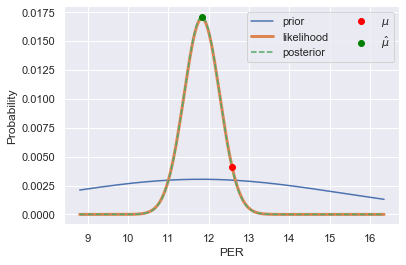

In [156]:
plot_pri_post_like(one_pos_one_year_d, μ, σ, log_prior_norm, log_likelihood, log_posterior_norm)
#TODO: plot also Uniform
#TODO: Take all this up

## Create a model for estimating the PER mean/std for prior

OK. So if we want to extract the best player with regards to his position, we need to be able to find the best fit for the distribution of each position.

We will use few methods:

- Baysian Inference
- ABC 
- ...

The goal will be to compute the model parameters $\Theta=(\mu , \sigma)$ for each position.

We want to use the PER mean and STD as prior.

Let's first look at the PER over the last 15 years

In [34]:
# TODO: Fetching as module
columns_to_convert = ['Age','G','MP','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%',
                    'TOV%','USG%','OWS' ,'DWS','WS','WS/48','OBPM','DBPM','BPM','VORP']
mean_per = []
std_per = []
for y in range(*years_range,1):
    url = 'https://www.basketball-reference.com/leagues/NBA_{}_advanced.html'.format(y)
    df=fetch_data(url)
    preprocess_df(columns_to_convert)
    mean_per.append(np.mean(df['PER']))
    std_per.append(np.std(df['PER']))

NameError: name 'fetch_data' is not defined

In [32]:
mean_per

[13.513054830287208,
 13.166666666666679,
 13.425765306122445,
 13.369210526315788,
 13.517847769028876,
 13.611111111111121,
 13.447814910025697,
 13.692171717171721,
 13.68337531486147,
 13.471219512195121,
 13.867303102625293,
 13.900726392251803,
 13.745762711864408,
 14.024396135265706,
 13.949761904761907]

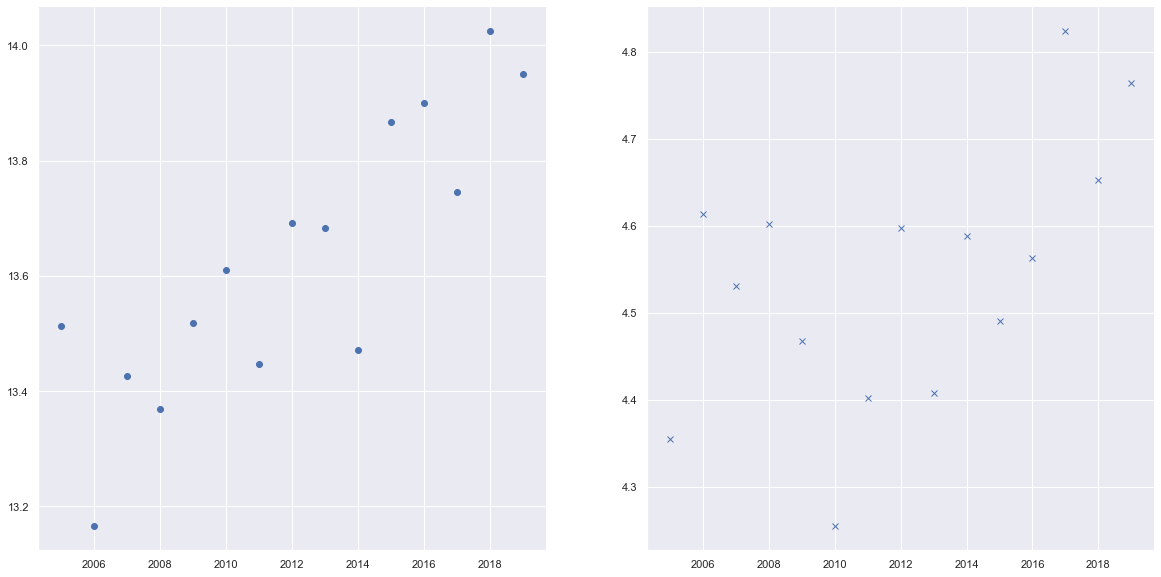

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].plot(range(*years_range), mean_per, 'o')
axes[1].plot(range(*years_range), std_per, 'x')
sns.despine()


In [34]:
from scipy.optimize import curve_fit

In [35]:
def lin_func(x,a,b):
    return a*x+b

In [36]:
pars, cov = curve_fit(f=lin_func, xdata=range(*years_range,1), ydata=mean_per)

In [37]:
pars

array([ 4.61911430e-02, -7.93108338e+01])

In [38]:
cov

array([[ 6.02323459e-05, -1.21187480e-01],
       [-1.21187480e-01,  2.43830332e+02]])

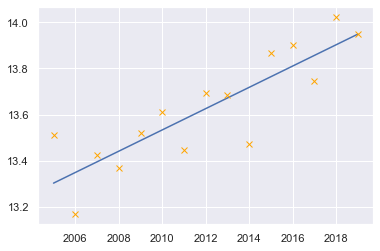

In [39]:
plt.plot(range(*years_range), lin_func(range(*years_range,1), pars[0], pars[1]))
plt.plot(range(*years_range), mean_per, 'x', color='orange')
plt.show()
#TODO: Add variance to the line. Maybe sample from the normal dist of a,b

In [40]:
def get_per(func, year, params):
    return func(year, *params)

In [41]:
get_per_mean_and_var(lin_func, 2016, pars)

NameError: name 'get_per_mean_and_var' is not defined

In [42]:
import statsmodels.api as sm

In [43]:
y = mean_per
X = sm.add_constant(range(*years_range)) # for intercept
results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     35.42
Date:                Sun, 23 Aug 2020   Prob (F-statistic):           4.81e-05
Time:                        23:14:15   Log-Likelihood:                 10.408
No. Observations:                  15   AIC:                            -16.82
Df Residuals:                      13   BIC:                            -15.40
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -79.3108     15.615     -5.079      0.0

/Users/amitklinger/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


# Baysian Inference for PER line

In [44]:
a_prior = scipy.stats.norm(5, 0.2)
b_prior = scipy.stats.norm(-9, 0.1)
σ_prior = scipy.stats.expon(0.1)

def log_prior(θ):
    a, b, σ = θ
    return a_prior.logpdf(a) + b_prior.logpdf(b) + σ_prior.logpdf(σ)

def log_likelihood(θ, x, y):
    a, b, σ = θ
    yhat = a * x + b
    return scipy.stats.norm(yhat, σ).logpdf(y).sum()

def log_posterior(θ, x, y):
    logpri = log_prior(θ)
    if np.isinf(logpri): return logpri
    return logpri + log_likelihood(θ, x, y)

In [45]:
ndim = 3
nwalkers = 50
nsteps  = 200
nburn = nsteps // 2
var_names = ['a', 'b', 'σ']

guesses = np.random.rand(nwalkers, ndim)
guesses[:, 0] = a_prior.rvs(nwalkers)
guesses[:, 1] = b_prior.rvs(nwalkers)
guesses[:, 2] = σ_prior.rvs(nwalkers)

In [46]:
x = range(*years_range,1)
y = mean_per

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, y])
sampler.run_mcmc(guesses, nsteps);

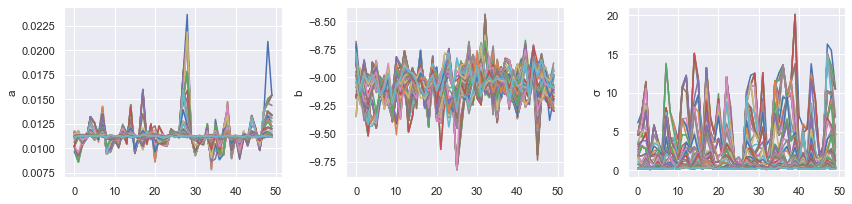

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, param in enumerate(['a', 'b', 'σ']):
    axes[i].plot(sampler.chain[:, nburn:, i])
    axes[i].set_ylabel(param)
fig.tight_layout()

In [48]:
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))
θ_bayes = samples.mean(axis=0)
# print("Normal: a={:.3f}, b={:.3f}".format(*θ_norm))
print("Bayes:  a={:.3f}, b={:.3f}, σ={:.3f}".format(*θ_bayes))

Bayes:  a=0.011, b=-9.067, σ=1.710


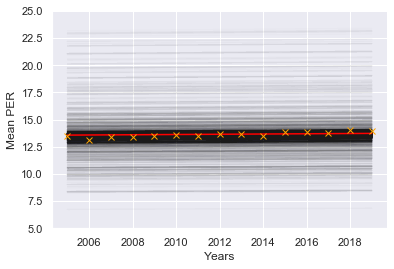

In [49]:
#plt.plot(lin_func(range(*years_range,1), pars[0], pars[1]))

for θi in samples:
    ai, bi, _ = θi
    yhat = ai * x + bi
    plt.plot(x, yhat, '-k', alpha=0.01)
    
a, b, σ = θ_bayes
yhat = a * x + b
plt.plot(x, yhat, color='red')
# comment out the next lines to get a predictive interval around the linear estimate
# plt.plot(x, yhat+σ, color=red)
# plt.plot(x, yhat-σ, color=red)

plt.plot(range(*years_range,1), mean_per, 'x', color='orange')
plt.ylim(5,25)

plt.xlabel('Years')
plt.ylabel('Mean PER')
sns.despine()

In [50]:
#TODO: Try to fit diffrent lines

In [51]:
from corner import corner

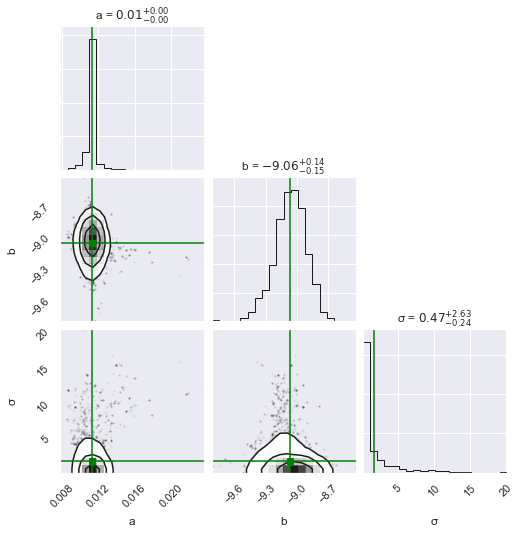

In [52]:
corner(
    samples, 
    smooth=True, 
    labels=var_names, 
    show_titles=True, 
    truths=θ_bayes, 
    truth_color="green"
);

In [ ]:
# Start of AMIT latest adds

# New MVP

In [34]:
# #TODO: Make MVPs path according to username (not hardcoded)
# mvps = '/Users/amitklinger/Documents/IDC/SciComPy/SciComPy/SciComPy_NBA/mvps.csv'
# df_mvp = pd.read_csv(mvps,header=1)
# df_mvp.Season = df_mvp.Season.str[0:2] + df_mvp.Season.str[-2:]
# #         df[col] = pd.to_numeric(df[col])
# df_mvp.Season = pd.to_numeric(df_mvp.Season)

# df_mvp[['Player','Tweat']] = df_mvp.Player.str.split('\\',expand=True)


In [39]:
years_range = (2013,2020)

In [40]:
dbb = data_fetcher.create_database(years_range)

In [44]:
dbb.loc[dbb['MVP']]

,Player,Pos,PER,Year,MVP
186,LeBron James,PF,31.6,2013,True
524,Kevin Durant,SF,29.8,2014,True
913,Stephen Curry,PG,28.0,2015,True
1333,Stephen Curry,PG,31.5,2016,True
2048,Russell Westbrook,PG,30.6,2017,True
2225,James Harden,SG,29.8,2018,True
2497,Giannis Antetokounmpo,PF,30.9,2019,True


In [45]:
def add_std_dist_2_db(db, μ, σ, year, pos):
    df1 = db.loc[(db['Year'] == year) & (db['Pos'] == pos)].copy()
    df1.loc[:, 'std_dist'] = round(std_dist(df1['PER'], μ, σ),2)
    db.loc[df1.index, 'std_dist'] = df1['std_dist']
    return 

In [46]:
add_std_dist_2_db(dbb, 15, 4, 2017, 'C')
add_std_dist_2_db(dbb, 14, 4.1, 2013, 'PF')

In [48]:
dbb.loc[dbb['Year']==2017]

,Player,Pos,PER,Year,MVP,std_dist
1659,Álex Abrines,SG,10.1,2017,False,NaN
1660,Quincy Acy,PF,11.8,2017,False,NaN
1661,Steven Adams,C,16.5,2017,False,0.38
1662,Arron Afflalo,SG,8.9,2017,False,NaN
1663,Alexis Ajinça,C,12.9,2017,False,-0.52
...,...,...,...,...,...,...
2067,Thaddeus Young,PF,14.9,2017,False,NaN
2068,Cody Zeller,C,16.7,2017,False,0.42
2069,Tyler Zeller,C,13.0,2017,False,-0.50
2070,Paul Zipser,SF,6.9,2017,False,NaN


In [316]:
from termcolor import colored
def get_max_per(df):
    max_per = df[df['PER'] == df['PER'].max()]
    max_per_val, max_per_player = max_per.iloc[0]['PER'], max_per.iloc[0]['Player']
    return max_per_val, max_per_player

def compare_mvp_vs_max_per(db, mvps):
    years = np.unique(db['Year'])
    for year in years:
        mvp_winner = mvps[mvps['Season'] == year].iloc[0]['Player']
        df = db[db['Year'] == year]
#         max_per = df[df['PER'] == df['PER'].max()]
#         max_per_val, max_per_player = max_per.iloc[0]['PER'], max_per.iloc[0]['Player']
        max_per_val, max_per_player = get_max_per(df)
        ccolor = 'grey' if max_per_player == mvp_winner else 'red'
        print (f"\033[4mYear: {year}\033[0m")
        print(colored('Player with maximum PER is {} with PER of {}.\nMVP Winner = {}'.format(max_per_player, max_per_val, mvp_winner),ccolor))

In [317]:
compare_mvp_vs_max_per(dbb, df_mvp)

Year: 2013
Player with maximum PER is LeBron James with PER of 31.6.
MVP Winner = LeBron James
Year: 2014
Player with maximum PER is Kevin Durant with PER of 29.8.
MVP Winner = Kevin Durant
Year: 2015
Player with maximum PER is Anthony Davis with PER of 30.8.
MVP Winner = Stephen Curry
Year: 2016
Player with maximum PER is Stephen Curry with PER of 31.5.
MVP Winner = Stephen Curry
Year: 2017
Player with maximum PER is Russell Westbrook with PER of 30.6.
MVP Winner = Russell Westbrook
Year: 2018
Player with maximum PER is James Harden with PER of 29.8.
MVP Winner = James Harden
Year: 2019
Player with maximum PER is Giannis Antetokounmpo with PER of 30.9.
MVP Winner = Giannis Antetokounmpo


In [337]:

def get_new_per(db, year):
    df = db[db['Year'] == year]
    unique_pos = np.unique(df['Pos'])
    print (f"\033[4mYear: {year}\033[0m")
    max_per_pos_dict = {}
    max_stds = 0
    max_pos = None
    for p in unique_pos:
        pos_df = df[df['Pos']==p]
        max_per_val, max_per_player = get_max_per(pos_df)
        std_d = std_dist(max_per_val, np.mean(pos_df['PER']), np.std(pos_df['PER']))
        if std_d > max_stds:
            max_stds = std_d
            max_pos = p
#         print (f'For position {p}:')
#         print (f"Player with maximum PER within position is {max_per_player} with PER = {max_per_val}")
#         print (f'Which is {std_d:.2f} far from mean value')
        max_per_pos_dict[p] = {'Player' : max_per_player, 'PER' : max_per_val, 'stds_dist' : np.round(std_d,2)}
    mvp_according_new_per = max_per_pos_dict[max_pos]
    print(colored('MVP According to new-PER calculation should be {} with PER of {}, stds_dist = {}'.format(mvp_according_new_per['Player'], mvp_according_new_per['PER'], mvp_according_new_per['stds_dist']),'cyan'))
    return max_per_pos_dict, max_pos


In [354]:
new_per_mvps = {}
for year in np.unique(dbb['Year']):
    pos_dict, max_pos = get_new_per(dbb, year)
#     new_per_mvps.append({'Year' : year, 'New_MVP' : pos_dict[max_pos]['Player']})
#     new_per_mvps.append({year : pos_dict[max_pos]['Player']})
    new_per_mvps[year] = pos_dict[max_pos]['Player']
print("*"*55)
print(new_per_mvps)

Year: 2013
MVP According to new-PER calculation should be Kevin Durant with PER of 28.3, stds_dist = 4.5
Year: 2014
MVP According to new-PER calculation should be Kevin Durant with PER of 29.8, stds_dist = 4.46
Year: 2015
MVP According to new-PER calculation should be Anthony Davis with PER of 30.8, stds_dist = 3.85
Year: 2016
MVP According to new-PER calculation should be Stephen Curry with PER of 31.5, stds_dist = 3.75
Year: 2017
MVP According to new-PER calculation should be DeMar DeRozan with PER of 24.0, stds_dist = 3.5
Year: 2018
MVP According to new-PER calculation should be James Harden with PER of 29.8, stds_dist = 4.2
Year: 2019
MVP According to new-PER calculation should be Giannis Antetokounmpo with PER of 30.9, stds_dist = 4.0
{2013: 'Kevin Durant', 2014: 'Kevin Durant', 2015: 'Anthony Davis', 2016: 'Stephen Curry', 2017: 'DeMar DeRozan', 2018: 'James Harden', 2019: 'Giannis Antetokounmpo'}


/Users/amitklinger/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [358]:
def compare_mvp_2_newmvp(mvps, new_per_mvps):
    for year in np.unique(dbb['Year']):
        mvp_winner = mvps[mvps['Season'] == year].iloc[0]['Player']
        new_mvp_winner = new_per_mvps[year]
        ccolor = 'grey' if mvp_winner == new_mvp_winner else 'red'
        print(colored("mvp_winner = {}".format(mvp_winner), ccolor))
        print(colored("new_mvp_winner = {}".format(new_mvp_winner), ccolor))
        print("*"*55)


compare_mvp_2_newmvp(df_mvp, new_per_mvps)


mvp_winner = LeBron James
new_mvp_winner = Kevin Durant
*******************************************************
mvp_winner = Kevin Durant
new_mvp_winner = Kevin Durant
*******************************************************
mvp_winner = Stephen Curry
new_mvp_winner = Anthony Davis
*******************************************************
mvp_winner = Stephen Curry
new_mvp_winner = Stephen Curry
*******************************************************
mvp_winner = Russell Westbrook
new_mvp_winner = DeMar DeRozan
*******************************************************
mvp_winner = James Harden
new_mvp_winner = James Harden
*******************************************************
mvp_winner = Giannis Antetokounmpo
new_mvp_winner = Giannis Antetokounmpo
*******************************************************
